In [3]:
# Env Setup
!pip install tensorflow librosa numpy matplotlib
import os, random, math
from pathlib import Path
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf

  Using cached tensorflow-2.20.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached mdurl-0.1.2-py3-none-a

In [4]:
# Audio Parameters
SAMPLE_RATE = 8000
WINDOW_SIZE = 0.025
FFT_SIZE = int(SAMPLE_RATE * WINDOW_SIZE)
HOP_SIZE = int(0.010 * SAMPLE_RATE)
N_MFCC = 32
MAX_DURATION = 2.0
EXPECTED_SAMPLES = int(SAMPLE_RATE * MAX_DURATION)
FIXED_FRAMES = 80
print("Sample rate:", SAMPLE_RATE)

Sample rate: 8000


In [5]:
# Load file paths
lang = "es"
data_path = "../dataset"
data_root = Path(data_path + "/" + lang)   
if not data_root.exists():
    # Fallback if running from a different directory depth
    data_root = Path("voiceRover/dataset/" + lang)

label_names = sorted([d.name for d in data_root.iterdir() if d.is_dir()])
label_to_idx = {n:i for i,n in enumerate(label_names)}

files = []
labels = []
for label in label_names:
    for f in sorted((data_root/label).glob("*.wav")):
        files.append(str(f))
        labels.append(label_to_idx[label])

print(f"Found {len(files)} files in {label_names}")

Found 40 files in ['backward', 'forward', 'left', 'right']


In [6]:
# ---- HELPER FUNCTIONS (Augmentation + Normalization) ----

def augment_audio(y, sr):
    # 1. Add Gaussian Noise
    noise_amp = 0.005 * np.random.uniform() * np.amax(y)
    y = y + noise_amp * np.random.normal(size=y.shape[0])
    # 2. Time Shift
    shift_samples = int(sr * 0.1)
    shift_direction = np.random.choice([-1, 1])
    y = np.roll(y, shift_samples * shift_direction)
    return y

def extract_mfcc(path, augment=False):
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    # Normalize Volume
    if y.size > 0:
        y = y / (np.max(np.abs(y)) + 1e-9)
    y, _ = librosa.effects.trim(y, top_db=20)
    
    # Augmentation
    if augment:
        y = augment_audio(y, sr)
    
    # Pad/Truncate
    if len(y) > EXPECTED_SAMPLES:
        y = y[:EXPECTED_SAMPLES]
    else:
        pad_len = EXPECTED_SAMPLES - len(y)
        if pad_len > 0:
            y = np.pad(y, (0, pad_len), mode='constant')

    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=FFT_SIZE, hop_length=HOP_SIZE)
    mfcc = mfcc.T.astype(np.float32)

    # --- NORMALIZATION (Fixes 'Flat' Image) ---
    mean = np.mean(mfcc, axis=0)
    std = np.std(mfcc, axis=0)
    mfcc = (mfcc - mean) / (std + 1e-6)
    
    return mfcc

In [7]:
# ---- DATASET EXPANSION ----
expanded_files = []
expanded_labels = []
AUGMENT_FACTOR = 15 

for f, l in zip(files, labels):
    for _ in range(AUGMENT_FACTOR):
        expanded_files.append(f)
        expanded_labels.append(l)

# Shuffle
pairs = list(zip(expanded_files, expanded_labels))
random.shuffle(pairs)
expanded_files, expanded_labels = zip(*pairs)
expanded_files = list(expanded_files)
expanded_labels = list(expanded_labels)

n_train = int(len(expanded_files) * 0.90)
print(f"New Dataset Size: {len(expanded_files)}")

New Dataset Size: 600


In [10]:
# ---- TF PIPELINE ----
def _load_and_preprocess(path_tensor, label):
    def _py_extract_func(p):
        # Handle both bytes and string tensor types
        if isinstance(p, bytes):
            path_str = p.decode('utf-8')
        else:
            path_str = str(p.numpy().decode('utf-8')) if hasattr(p, 'numpy') else str(p)
        mf = extract_mfcc(path_str, augment=True)
        # Fix length to 80 frames
        if mf.shape[0] >= FIXED_FRAMES:
            mf_fixed = mf[:FIXED_FRAMES, :]
        else:
            pad_rows = FIXED_FRAMES - mf.shape[0]
            mf_fixed = np.vstack([mf, np.zeros((pad_rows, mf.shape[1]), dtype=np.float32)])
        return mf_fixed

    mf = tf.py_function(func=_py_extract_func, inp=[path_tensor], Tout=tf.float32)
    mf.set_shape((FIXED_FRAMES, N_MFCC))
    mf = tf.expand_dims(mf, -1)
    return mf, label

files_tf = tf.constant(expanded_files, dtype=tf.string)
labels_tf = tf.constant(expanded_labels, dtype=tf.int32)

ds_all = tf.data.Dataset.from_tensor_slices((files_tf, labels_tf))
ds_all = ds_all.shuffle(buffer_size=len(expanded_files), reshuffle_each_iteration=True)
ds_all = ds_all.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = ds_all.take(n_train).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_all.skip(n_train).batch(32).prefetch(tf.data.AUTOTUNE)

/Users/felipe.santos/Projects/voiceRover/.venv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


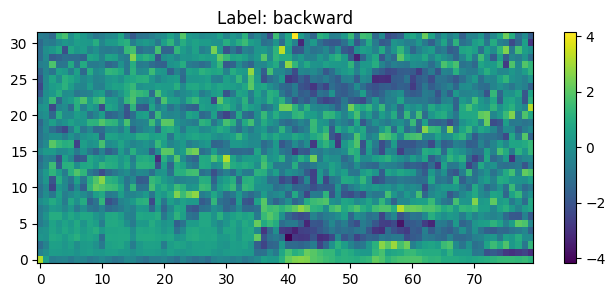

2025-12-02 12:26:17.163738: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Check one MFCC
for x, y in ds_all.take(1):
    plt.figure(figsize=(8,3))
    plt.imshow(x.numpy().squeeze().T, origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f"Label: {label_names[y]}")
    plt.show()

In [12]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Input(shape=(FIXED_FRAMES, N_MFCC, 1)),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.DepthwiseConv2D((3,3), padding='same', activation='relu'),
    layers.Conv2D(24, (3,3), padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(label_names), activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 80, 32, 16)     │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 32, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 24)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,732 (18.48 KB)

 Trainable params: 4,732 (18.48 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.2167 - loss: 1.3878 - val_accuracy: 0.2500 - val_loss: 1.3874
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.2167 - loss: 1.3878 - val_accuracy: 0.2500 - val_loss: 1.3874
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2481 - loss: 1.3862 - val_accuracy: 0.2833 - val_loss: 1.3850
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2481 - loss: 1.3862 - val_accuracy: 0.2833 - val_loss: 1.3850
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.2648 - loss: 1.3855 - val_accuracy: 0.2000 - val_loss: 1.3828
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.2648 - loss: 1.3855 - val_accuracy: 0.2000 - val_loss: 1.3828
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2704 - loss: 1.3846 - val_accuracy: 0.3667 - val_loss: 1.3807
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2704 - loss: 1.3846 - val_accuracy: 0.

In [14]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
    
print("Model saved to model.tflite")
# !xxd -i model.tflite > model_data.cc  # Uncomment to generate C array on Linux/Mac

INFO:tensorflow:Assets written to: /var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpj50tskdw/assets


INFO:tensorflow:Assets written to: /var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpj50tskdw/assets


Saved artifact at '/var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpj50tskdw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 32, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  13157541136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13157533456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13157542096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13157547856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13157536336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13157537680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13157534800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13157541712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13157534992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13157536528: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved to

W0000 00:00:1764689294.261937 15314771 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764689294.261948 15314771 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-02 12:28:14.262771: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpj50tskdw
2025-12-02 12:28:14.263693: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-02 12:28:14.263700: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/qr/9c5pg6b52rg8ykvxgq54qk8w0000gq/T/tmpj50tskdw
I0000 00:00:1764689294.266965 15314771 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-12-02 12:28:14.267806: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-02 12:28:14.286516: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/fol